In [1]:
import math
import sys
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat, savemat
from scipy import signal
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential,  Model
from keras.optimizers import Adam, SGD
from keras.layers import MaxPooling2D, Conv2D, MaxPooling1D, Conv1D, Dense, Flatten, AveragePooling1D, LSTM, Dropout, Input, Concatenate
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [2]:
data1 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean1.npz')
data2 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean2.npz')
data3 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean3.npz')
data4 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean4.npz')
data5 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean5.npz')

In [3]:
def truncate(n,i):
  return math.floor(n*10**i)/10**i

train_time = np.concatenate((data1['Time'], data2['Time'], data3['Time'], data4['Time'], data5['Time']), axis=None)
ttime = [truncate(i,2) for i in train_time]
print(np.shape(ttime))
ttime = np.reshape(ttime, (np.shape(ttime)[0], 1))
print(ttime)
print(np.shape(ttime))

del train_time

(1324032,)
[[2102.67]
 [2102.67]
 [2102.67]
 ...
 [3426.96]
 [3426.96]
 [3426.96]]
(1324032, 1)


In [4]:
train_data = np.concatenate((data1['AcData'], data2['AcData'], data3['AcData'], data4['AcData'], data5['AcData']), axis=0)
print(train_data)
print(np.shape(train_data))

[[ 21   9  26 ... -31 -33 -45]
 [ 17  20  28 ... -25 -30 -41]
 [  8  10  17 ... -17 -20 -38]
 ...
 [ 21  30  29 ... 232 242 238]
 [ 27  10  20 ... 248 239 228]
 [ 58  93 111 ... 249 224 216]]
(1324032, 1568)


In [5]:
del data1, data2, data3, data4, data5

In [6]:
# full_data = np.hstack((ttime, train_data))
# print(full_data)
# print(np.shape(full_data))

ttime = pd.DataFrame(ttime).rename(columns={0:'Time'})
full_df = ttime.join(pd.DataFrame(train_data))
print(full_df)
del train_data, ttime

            Time   0   1    2    3    4  ...  1562  1563  1564  1565  1566  1567
0        2102.67  21   9   26   20   31  ...   -11   -14   -25   -31   -33   -45
1        2102.67  17  20   28   24   29  ...   -10   -19   -26   -25   -30   -41
2        2102.67   8  10   17   13   32  ...   -15   -15   -19   -17   -20   -38
3        2102.67   2   5   14    8   17  ...    10     5   -18   -21   -35   -40
4        2102.67  15  15   10   22   29  ...   -13   -18   -18   -17   -24   -38
...          ...  ..  ..  ...  ...  ...  ...   ...   ...   ...   ...   ...   ...
1324027  3426.95  24  22   18   36   36  ...   250   258   253   233   231   232
1324028  3426.96  24  16   21   32   31  ...   261   246   255   245   232   227
1324029  3426.96  21  30   29   30   25  ...   264   264   246   232   242   238
1324030  3426.96  27  10   20   29   28  ...   265   252   258   248   239   228
1324031  3426.96  58  93  111  124  115  ...   265   248   245   249   224   216

[1324032 rows x 1569 column

In [7]:
# full_df = full_df.groupby(by='Time').mean().reset_index(drop=True).astype('float32').dtypes
# full_df['Time'] = full_df['Time'].shift(-1).fillna(truncate(full_df.iloc[-1,0]+0.01,2))

full_df = full_df.drop_duplicates(subset=['Time'], keep='last').reset_index(drop=True)
full_df = full_df.set_index('Time')
print(full_df)

         0     1     2     3     4     5     ...  1562  1563  1564  1565  1566  1567
Time                                         ...                                    
2102.67    18    19     8    24    22    31  ...    -7   -13   -26   -29   -40   -47
2102.68    11    13    13    17    35    33  ...   -12   -18   -24   -25   -35   -38
2102.69    23    30    23    38    37    39  ...    -9   -18   -21   -25   -27   -38
2102.70    18    18    25    22    35    41  ...   -12   -16   -17   -22   -30   -30
2102.71    16    14    22    29    43    46  ...    -7    -5   -15   -28   -14   -36
...       ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
3426.92    24    15    13    25    32    32  ...   249   249   246   244   248   236
3426.93    16    15    27    21    49    32  ...   256   251   237   249   248   235
3426.94    11     1     6    17    23    28  ...   249   246   264   250   243   237
3426.95    24    22    18    36    36    26  ...   250   258   25

In [8]:
full_df2 = full_df.rolling(40, min_periods=1).mean().astype('float32')
print(full_df2)

              0          1          2     ...        1565        1566        1567
Time                                      ...                                    
2102.67  18.000000  19.000000   8.000000  ...  -29.000000  -40.000000  -47.000000
2102.68  14.500000  16.000000  10.500000  ...  -27.000000  -37.500000  -42.500000
2102.69  17.333334  20.666666  14.666667  ...  -26.333334  -34.000000  -41.000000
2102.70  17.500000  20.000000  17.250000  ...  -25.250000  -33.000000  -38.250000
2102.71  17.200001  18.799999  18.200001  ...  -25.799999  -29.200001  -37.799999
...            ...        ...        ...  ...         ...         ...         ...
3426.92  16.350000  19.775000  16.225000  ...  240.600006  235.449997  229.524994
3426.93  15.950000  19.125000  16.325001  ...  241.024994  236.000000  230.100006
3426.94  16.125000  18.799999  16.100000  ...  241.574997  236.574997  230.649994
3426.95  17.525000  20.299999  17.400000  ...  242.074997  237.074997  231.274994
3426.96  18.3250

In [9]:
data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'TTF':data['TTF'].ravel()})
m_t = m_t[:][175604:175604+132400].reset_index(drop=True)
print(m_t)

           Time  TTF
0       2102.91  0.0
1       2102.92  0.0
2       2102.93  0.0
3       2102.94  0.0
4       2102.95  0.0
...         ...  ...
132395  3426.86  0.0
132396  3426.87  0.0
132397  3426.88  0.0
132398  3426.89  0.0
132399  3426.90  0.0

[132400 rows x 2 columns]


In [10]:
#df = full_df.merge(m_t, on='Time').reset_index(drop=True)
df = full_df.reset_index().merge(m_t, on='Time').reset_index(drop=True)
xdf = df.drop(['Time', 'TTF'], axis=1)
ydf = df[['TTF']]
print(xdf)
print(ydf)


        0     1     2     3     4     5     ...  1562  1563  1564  1565  1566  1567
0          3    12    15    20    46    28  ...    -6   -11   -16   -23   -31   -40
1         15    16    13    29    33    39  ...    -6    -9   -15   -15   -25   -42
2          9    18     9    28    44    29  ...   -15   -13   -23   -27   -28   -25
3         22    31    17    24    41    27  ...    -3    -6   -18   -25   -24   -28
4         18    17    19    17    37    35  ...   -18   -16   -20   -26   -35   -44
...      ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
132370    25    37    15    19    39    30  ...   256   246   251   242   224   227
132371    20    14     7    10    27    18  ...   258   259   245   238   230   231
132372    22     9    17    27    33    29  ...   260   249   235   241   234   219
132373    14    19    17    25    33    36  ...   259   260   252   253   256   235
132374    28    23    20    34    31    33  ...   251   244   237   236   22

In [11]:
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)
print(X_train.shape, X_val.shape, x_test.shape)
print(Y_train.shape, Y_val.shape, y_test.shape)

(95310, 1568) (10590, 1568) (26475, 1568)
(95310, 1) (10590, 1) (26475, 1)


In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
x_test = scaler.transform(x_test)

X_train = np.reshape(np.array(X_train), (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(np.array(X_val), (X_val.shape[0], X_val.shape[1], 1))
x_test = np.reshape(np.array(x_test), (x_test.shape[0], x_test.shape[1], 1))
print(X_train.shape, X_val.shape, x_test.shape)

(95310, 1568, 1) (10590, 1568, 1) (26475, 1568, 1)


In [30]:


inp = Input(shape=(X_train.shape[1:]), name='inp')
conv1 = Conv1D(16, kernel_size=100,  kernel_initializer='random_normal', activation='relu')(inp)
pool1 = MaxPooling1D(pool_size=20, strides=1)(conv1)
conv2 = Conv1D(32, kernel_size=50, kernel_initializer='random_normal', activation='relu')(pool1)
# pool2 = MaxPooling1D(pool_size=15, strides=1)(conv2)
# conv3 = Conv1D(32, kernel_size=50, kernel_initializer='random_normal', activation='relu')(pool2)
pool3a = MaxPooling1D(pool_size=10, strides=1)(conv2)


conv1 = Conv1D(16, kernel_size=100, kernel_initializer='random_normal', activation='relu')(inp)
pool1 = MaxPooling1D(pool_size=20, strides=1)(conv1)
conv2 = Conv1D(32, kernel_size=50, strides=1, kernel_initializer='random_normal', activation=None)(pool1)
# pool2 = MaxPooling1D(pool_size=15, strides=1)(conv2)
# conv3 = Conv1D(32, kernel_size=50, strides=1, kernel_initializer='random_normal', activation='relu')(pool2)
pool3b = MaxPooling1D(pool_size=10, strides=1)(conv2)

c = Concatenate()([pool3a, pool3b])
# conv1 = Conv1D(16, kernel_size=100, kernel_initializer='random_normal', activation='relu')(c)
# pool1 = MaxPooling1D(pool_size=20, strides=1)(conv1)

f2 = Flatten(name='Features')(c)

m = Dense(128, kernel_initializer = 'random_normal', activation='relu')(f2)
m = Dense(64, kernel_initializer = 'random_normal', activation='relu')(m)
m = Dense(16, kernel_initializer = 'random_normal', activation=None)(m)
op = Dense(1, kernel_initializer = 'random_normal', activation=None)(m)
model = Model(inputs=[inp], outputs=[op])

model.compile(loss='mse', optimizer=Adam())

model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_val, Y_val))

print(model.summary())

Epoch 1/10
2979/2979 [==============================] - 53s 18ms/step - loss: 0.7965 - val_loss: 0.7908
Epoch 2/10
2979/2979 [==============================] - 52s 17ms/step - loss: 0.3244 - val_loss: 0.3981
Epoch 3/10
2979/2979 [==============================] - 52s 17ms/step - loss: 0.2493 - val_loss: 0.5348
Epoch 4/10
2979/2979 [==============================] - 52s 17ms/step - loss: 0.1979 - val_loss: 0.4010
Epoch 5/10
2979/2979 [==============================] - 52s 17ms/step - loss: 0.1755 - val_loss: 0.3220
Epoch 6/10
2979/2979 [==============================] - 52s 17ms/step - loss: 0.1707 - val_loss: 0.2641
Epoch 7/10
2979/2979 [==============================] - 52s 17ms/step - loss: 0.1619 - val_loss: 0.2843
Epoch 8/10
2979/2979 [==============================] - 52s 17ms/step - loss: 0.1530 - val_loss: 0.2794
Epoch 9/10
2979/2979 [==============================] - 52s 17ms/step - loss: 0.1454 - val_loss: 0.7390
Epoch 10/10
2979/2979 [==============================] - 52s 17m

In [31]:
# Evaluate the model
y_predTrain = model.predict(X_train)
y_predTrain = pd.DataFrame(y_predTrain).rolling(20, min_periods=1).mean().astype('float32')
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
y_predVal = pd.DataFrame(y_predVal).rolling(20, min_periods=1).mean().astype('float32')
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  


start_time = time.time()
y_predTest = model.predict(x_test)
y_predTest = pd.DataFrame(y_predTest).rolling(20, min_periods=1).mean().astype('float32')
end_time = time.time()
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))


print("R^2 scores: ", train_r2, val_r2, test_r2)
print("RMSE: ", train_rmse, val_rmse, test_rmse)
print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))


R^2 scores:  0.7917746831332774 0.7671138290391605 -1.061167534274246
RMSE:  0.4789840879625111 0.5524029820348709 1.6509698438475713

---Time for Test data prediction: 4.06065536 seconds ---


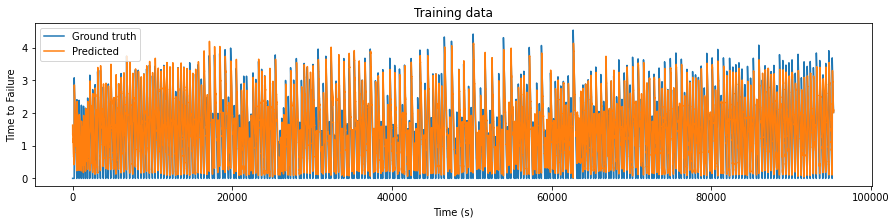

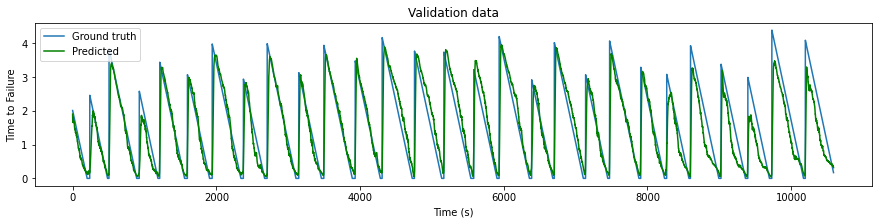

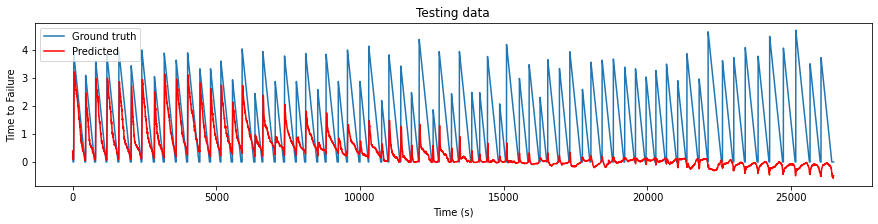

In [32]:
def results_plot(fig_no, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(15,3))
  plt.plot(gt)
  plt.plot(pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Time to Failure')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, Y_train, y_predTrain, 'Training data', '')
results_plot(2, Y_val.values, y_predVal, 'Validation data', 'g')
results_plot(3, y_test.values, y_predTest.values, 'Testing data', 'r')